In [ ]:
"""
@Josh Boquiren
OTIS Lab MUSC
7.21.2023

Notes:
- the purpose of this code is to validate the current classification model
"""

## Pilot

In [2]:
#import libraries

#data manipulation
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#directory and file manager
import os

#statistics
import scipy.stats as stats
import scipy.io as sio


In [3]:
#directories and animals

try:
    user = 'jboqu'

    main_dir = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\LC-PrL-DREADDs_Self-Admin_Analysis\active-lever_analysis\CueRein-All'%(user)
    main_results = os.path.join(main_dir, 'results')

    #all CueRein Data
    ALL_cueRein_dir = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data\CueRein'%(user)
    ALL_cueRein_labels = np.load(os.path.join(ALL_cueRein_dir, 'cluster_list_per_session_CueDrugTMT.npy'))
except:
    user = 'OtisLab'

    main_dir = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\LC-PrL-DREADDs_Self-Admin_Analysis\active-lever_analysis\CueRein-All'%(user)
    main_results = os.path.join(main_dir, 'results')

    #all CueRein Data
    ALL_cueRein_dir = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data\CueRein'%(user)
    ALL_cueRein_labels = np.load(os.path.join(ALL_cueRein_dir, 'cluster_list_per_session_CueDrugTMT.npy'))

print('User:', user)
print('Base directory:', main_dir)
print('Results directory:', main_results)

ALL_cueRein_animals = [
    'CTL1',
    'ER-L1',
    'ER-L2',
    'IG-19',

    'LCDD-PGa1',
    'LCDD-PGa3',
    'LCDD-PGa4',
    'LCDD-PGa5',
    'LCDD-PGa6', 

    'LCDD-PGa-T1',
    'LCDD-PGa-T2',
    'LCDD-PGa-T3',
    'LCDD-PGa-T4',
    'LCDD-PGa-T5',

    'PGa-T1',
    'PGa-T2',
    'PGa-T3'

]

User: jboqu
Base directory: C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\LC-PrL-DREADDs_Self-Admin_Analysis\active-lever_analysis\CueRein-All
Results directory: C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\LC-PrL-DREADDs_Self-Admin_Analysis\active-lever_analysis\CueRein-All\results


In [4]:
#frame rate variables
frameaveraging = 4
timebetweenframes = 33.3333
framerate = 30
framerate = timebetweenframes/frameaveraging #raw frame rate
averagedframerate = timebetweenframes/frameaveraging #averaged frame rate
print('Frame rate:', framerate)
print('Averaged frame rate:', averagedframerate)

#window size variables
pre_window_size = int(10*framerate)
window_size =  int((pre_window_size*2)+(3*framerate))
post_window_size = window_size - pre_window_size
baselinefirstframe = 0
baselinelastframe = int(1*framerate)
infusionframe = int(pre_window_size+(3*framerate))
print('Prewindow size:', pre_window_size)
print('Window size:', window_size)
print('Postwindow size:', post_window_size)

Frame rate: 8.333325
Averaged frame rate: 8.333325
Prewindow size: 83
Window size: 190
Postwindow size: 107


## Multivoxel Pattern Analysis *(decoding)*

### Pilot

In [5]:
#import libraries
import numpy as np
from os import system
from IPython.display import clear_output
from pandas import plotting
import traceback


from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
import logging
from io import StringIO
import smtplib

#classifier algorithms
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

#search algorithms
# from hyperopt import tpe, Trials, fmin, hp
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from statsmodels.distributions.empirical_distribution import ECDF

#metrics and preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, RocCurveDisplay, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize


In [6]:
#email alert exception handler

def send_email_crash_notification(crash_message):
    email = 'j.boquiren98@gmail.com'
    send_to_email = 'j.boquiren98@gmail.com'
    subject = 'ERROR!'
    msg = MIMEMultipart()
    msg['From'] = email
    msg['To'] = send_to_email
    msg['Subject'] = subject
    message = crash_message
    msg.attach(MIMEText(message, 'plain'))
    
    # Send the message via SMTP server.
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.login('j.boquiren98@gmail.com', 'eqepindlhavrnwvm')
    text = msg.as_string()
    server.sendmail(email, send_to_email, text)
    server.quit()
    print('Email sent to ' + str(send_to_email))
    return True

#email alert exception handler

def send_email_finished_notification(message):
    email = 'j.boquiren98@gmail.com'
    send_to_email = 'j.boquiren98@gmail.com'
    subject = 'FINISHED!'
    msg = MIMEMultipart()
    msg['From'] = email
    msg['To'] = send_to_email
    msg['Subject'] = subject
    message = message
    msg.attach(MIMEText(message, 'plain'))
    
    # Send the message via SMTP server.
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.login('j.boquiren98@gmail.com', 'eqepindlhavrnwvm')
    text = msg.as_string()
    server.sendmail(email, send_to_email, text)
    server.quit()
    print('Email sent to ' + str(send_to_email))
    return True

In [7]:
#decoding variables of interest
decoding = 'Neuron'
variable = 'Cue'
numclusters = 4

#initialize epochs
baseline_epoch = [0,8]
response_epoch = [pre_window_size-9, pre_window_size-1]

numshuffles = 1 
uniquelabels = np.arange(numclusters)
numneuronsincluster = np.nan*np.ones((numclusters,))

print('Baseline epoch:', baseline_epoch)
print('Response epoch:', response_epoch)

Baseline epoch: [0, 8]
Response epoch: [74, 82]


In [8]:
#date of iteration
date = '7-24-23_pt3'

#decoding results base directory
decoding_results_dir = os.path.join(main_results, 'decoding')

iteration_results = os.path.join(decoding_results_dir, date)
if os.path.exists(iteration_results):
    print('Iteration results folder exists for:', date)
else:
    os.mkdir(iteration_results)
    print('Made iteration results folder for:', date)

iteration_dictionaries = os.path.join(iteration_results, 'dictionaries')
if os.path.exists(iteration_dictionaries):
    print('Iteration dictionaries folder exists for:', date)
else:
    os.mkdir(iteration_dictionaries)
    print('Made iteration dictionaries folder for:', date)

Iteration results folder exists for: 7-24-23_pt3
Iteration dictionaries folder exists for: 7-24-23_pt3


### Decoding

In [9]:
classification_accuracy = {}
classification_accuracy['LCDD'] = {}
classification_accuracy['Gi-DREADDs'] = {}

#pipeline
pipe = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(0,1))), 
    ('classifier', SVC(kernel='rbf'))
    ])
parameters = {
    'classifier__C': [1e-2, 1e-1, 1e0, 1e1, 1e2], 
    'classifier__gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2]
    }
search = GridSearchCV(pipe, parameters, cv=10, n_jobs=-1, refit=True)

#### CueRein Population - averaged trials

In [26]:
#running pipeline

groups = [
    'CueRein_averaged-trials', 
    ]
animal_groups = [
    ALL_cueRein_animals,
     ]
dirs = [
    ALL_cueRein_dir, 
    ]
    
for index in range(len(animal_groups)):
    group = groups[index]
    animals = animal_groups[index]
    indir = dirs[index]
    classification_accuracy[group] = {}
    classification_accuracy[group]['unshuffled'] = {}
    classification_accuracy[group]['shuffled'] = {}
    for animal in animals:
        fovs = next(os.walk(os.path.join(indir, animal)))[1]
        for fov in sorted(fovs):
            trials = np.load(os.path.join(indir, animal, fov, 'aligned_active_lever_data.npy'))
            flags = np.load(os.path.join(indir, animal, fov, 'classificationFlags.npy'))
            num_trials = trials.shape[0]
            frames = trials.shape[1]
            num_neurons = trials.shape[2]
            try:
                """
                This portion can be edited to decode all trials per neuron or averaged trials per neuron.
                For all trials:
                - baseline and response array shapes should match trial file shape (3D array)
                - reference per neuron should look like -> trials[:, epoch of interest, neuron]
                - y should classify baseline as 0s, and response as 1s -> np.hstack((np.zeros(baseline.shape[0]), np.ones(response.shape[0])))

                For trial means per neuron:
                - baseline and response arrays should be an array of neurons by trials (2D array)
                - reference per neuron should look like -> np.nanmean(trials[:, epoch of interest, neuron], axis=1)
                - the above reference gets assigned to each neuron in respective array -> baseline[:,neuron] = [...]

                Note that the temporary arrays below are np.ones or np.zeros, not an array of np.nans*np.ones as in the previous codes.
                Having NaN values will thwart the accuracy of the decoding and may also return an accuracy of NaN.
                """            
                for neuron in range(trials.shape[2]):
                    print('Current animal: %s, Neurons left: %s'%(animal, (num_neurons-neuron)))
                    baseline = np.zeros((num_trials, num_neurons))
                    response = np.zeros((num_trials, num_neurons))
                    baseline[:, neuron] = np.nanmean(trials[:, baseline_epoch[0]:baseline_epoch[1], neuron], axis=1)
                    response[:, neuron] = np.nanmean(trials[:, response_epoch[0]:response_epoch[1], neuron], axis=1)
                    X = np.vstack((baseline, response))
                    y = np.hstack((np.zeros(baseline.shape[0]), np.ones(response.shape[0]))) #baseline classified as 0s, response classified as 1s
                    search.fit(X, y)
                    classification_accuracy[group]['unshuffled'][neuron] = search.best_score_
                    shuffled_y = np.random.permutation(y)
                    search.fit(X, shuffled_y)
                    classification_accuracy[group]['shuffled'][neuron] = search.best_score_
                    clear_output()
            except Exception as e:
                print('*** Error: %s ***'%(e))
send_email_finished_notification('Decoding finished!')

Current animal: ER-L1, Neurons left: 167


KeyboardInterrupt: 

In [35]:
#save dictionaries as .npy files

for index in range(len(groups)):
    group = groups[index]
    unshuffled = np.array(list(dict.items(classification_accuracy[group]['unshuffled'])))[:,1]
    shuffled = np.array(np.squeeze(list(dict.values(classification_accuracy[group]['shuffled']))))
    stacked = np.vstack((unshuffled, shuffled))
    np.save(os.path.join(iteration_dictionaries, '%s_%s_decoding-dict.npy'%(date, group)), stacked)     

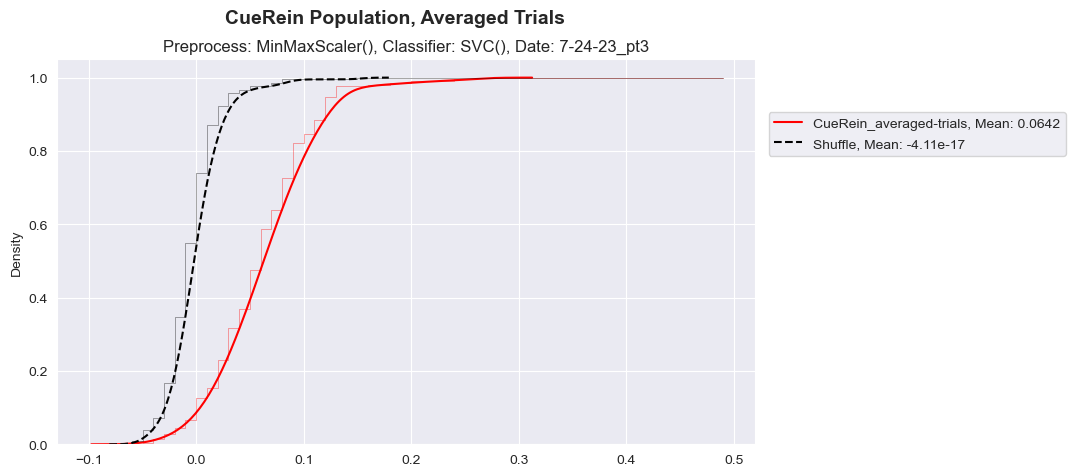

In [39]:
#plotting groups

groups = [
    'CueRein_averaged-trials', 
    ]

colors = ['red', 'green', 'blue']
bins = np.arange(-0.1,0.5,0.01)
sns.set_style('darkgrid')
plt.rcParams["figure.figsize"] = (9,5)
all_shuffled = []
for index in range(len(groups)):
    group = groups[index]
    c = colors[index]
    decode_values = np.load(os.path.join(iteration_dictionaries, '%s_%s_decoding-dict.npy'%(date, group)))
    unshuffle = decode_values[0]
    shuffle = decode_values[1]
    shuffle_mean = np.mean(shuffle)
    unshuffle = unshuffle - shuffle_mean #normalize by subtracting mean of shuffled data from unshuffled data
    shuffle = shuffle - shuffle_mean
    for neuron_accuracy in shuffle:
        all_shuffled.append(neuron_accuracy)
    sns.kdeplot(
        unshuffle, 
        label='%s, Mean: %s'%(group, '{0:.3g}'.format(np.mean(np.array(unshuffle)))), 
        cumulative=True, 
        color=c
        )
    sns.histplot(
        unshuffle,
        element='step',
        fill=False,
        cumulative=True,
        stat='density',
        bins=bins,
        color=c,
        alpha=.5,
        linewidth=.5
        )
sns.kdeplot(all_shuffled, label='Shuffle, Mean: %s'%('{0:.3g}'.format(np.mean(np.array(all_shuffled)))), cumulative=True, color='k', linestyle='--')
sns.histplot(
        all_shuffled,
        element='step',
        fill=False,
        cumulative=True,
        stat='density',
        bins=bins,
        color='k',
        alpha=.5,
        linewidth=.5
        )
plt.legend(loc=(1.02,.75), fontsize=10)
plt.suptitle('CueRein Population, Averaged Trials', fontsize=14, fontweight='bold')
plt.title('Preprocess: %s, Classifier: %s, Date: %s'%(str(pipe['scaler']), str(pipe['classifier']), date))

plt.savefig(os.path.join(iteration_results, 'CueRein_Population_averaged-trials.PDF'), format='PDF', bbox_inches="tight")

plt.show()

CueRein_averaged-trials


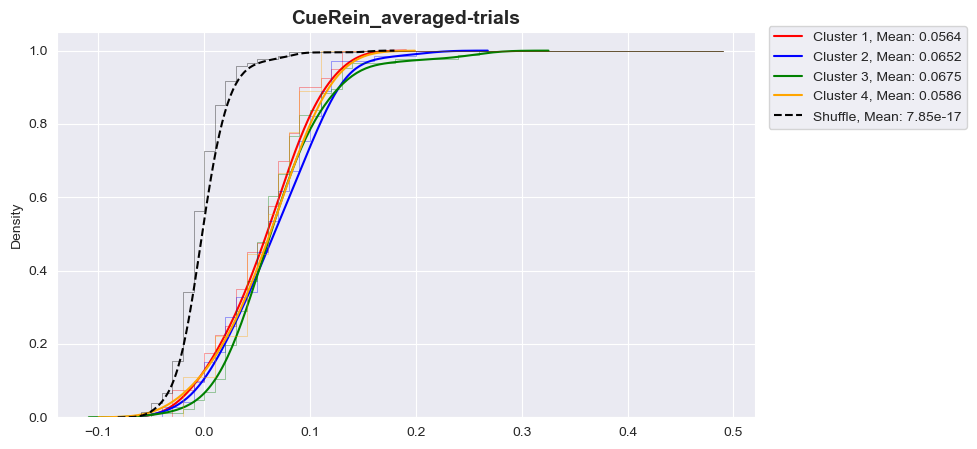

In [40]:
#plotting clusters per group

groups = [
    'CueRein_averaged-trials'
    ]
labels_dir = [ALL_cueRein_labels]

colors=[['tab:red'],['tab:orange'],['tab:blue'],['tab:purple']]
bins = np.arange(-.10,.5,0.01)
for index in range(len(groups)):
    print(groups[index])
    group = groups[index]
    cluster_labels = labels_dir[index]
    decode_values = np.load(os.path.join(iteration_dictionaries, '%s_%s_decoding-dict.npy'%(date, group)))
    unshuffle = decode_values[0]
    shuffle = decode_values[1]
    cluster_all_shuffle = []
    for c, cluster in enumerate(uniquelabels): 
        cluster_unshuffle_values = unshuffle[np.where(cluster_labels[:unshuffle.shape[0]]==c)]
        cluster_shuffle_values = shuffle[np.where(cluster_labels[:shuffle.shape[0]]==c)]
        cluster_shuffled_mean = np.mean(cluster_shuffle_values)
        cluster_unshuffle_values = cluster_unshuffle_values - cluster_shuffled_mean #normalize by subtracting mean shuffled values of cluster
        cluster_shuffle_values = cluster_shuffle_values -  cluster_shuffled_mean
        for neuron_accuracy in cluster_shuffle_values:
            cluster_all_shuffle.append(neuron_accuracy)
        sns.set_style('darkgrid')
        sns.kdeplot(
            cluster_unshuffle_values, 
            label='Cluster %s, Mean: %s'%(cluster+1, '{0:.3g}'.format(np.mean(cluster_unshuffle_values))), 
            cumulative=True, 
            color=colors[c])
        sns.histplot(
            cluster_unshuffle_values,
            element='step',
            fill=False,
            cumulative=True,
            stat='density',
            bins=bins,
            color=colors[c],
            alpha=.5,
            linewidth=.5
        )
    sns.kdeplot(
        cluster_all_shuffle, 
        label='Shuffle, Mean: %s'%('{0:.3g}'.format(np.mean(cluster_all_shuffle))), 
        cumulative=True, 
        color='k', 
        linestyle='--')
    sns.histplot(
            cluster_all_shuffle,
            element='step',
            fill=False,
            cumulative=True,
            stat='density',
            bins=bins,
            color='k',
            alpha=.5,
            linewidth=.5
        )
    plt.title(group, fontsize=14, fontweight='bold')
    plt.legend(loc=(1.02,.75), fontsize=10)

    plt.savefig(os.path.join(iteration_results, '%s_averaged-trials_Clusters.PDF'%(group)), format='PDF', bbox_inches="tight")

    plt.show()

#### CueRein Population - all trials

In [27]:
#running pipeline

groups = [
    'CueRein_all-trials', 
    ]
animal_groups = [
    ALL_cueRein_animals,
     ]
dirs = [
    ALL_cueRein_dir, 
    ]
    
for index in range(len(animal_groups)):
    group = groups[index]
    animals = animal_groups[index]
    indir = dirs[index]
    classification_accuracy[group] = {}
    classification_accuracy[group]['unshuffled'] = {}
    classification_accuracy[group]['shuffled'] = {}
    for animal in animals:
        fovs = next(os.walk(os.path.join(indir, animal)))[1]
        for fov in sorted(fovs):
            trials = np.load(os.path.join(indir, animal, fov, 'alignedActiveLeverCueData.npy'))
            flags = np.load(os.path.join(indir, animal, fov, 'classificationFlags.npy'))
            cue_trials = trials[np.where(flags==1),:,:] #separate cue trials from no-cue trials
            no_cue_trials = trials[np.where(flags==0),:,:]
            try:  
                """
                This portion can be edited to decode all trials per neuron or averaged trials per neuron.
                For all trials:
                - baseline and response array shapes should match trial file shape (3D array)
                - reference per neuron should look like -> trials[:, epoch of interest, neuron]
                - y should classify baseline as 0s, and response as 1s -> np.hstack((np.zeros(baseline.shape[0]), np.ones(response.shape[0])))

                For trial means per neuron:
                - baseline and response arrays should be an array of neurons by trials (2D array)
                - reference per neuron should look like -> np.nanmean(trials[:, epoch of interest, neuron], axis=1)
                - the above reference gets assigned to each neuron in respective array -> baseline[:,neuron] = [...]

                Note that the temporary arrays below are np.ones, not an array of np.nans*np.ones as in the previous codes.
                Having NaN values will thwart the accuracy of the decoding and may also return an accuracy of NaN.
                """              
                for neuron in range(trials.shape[2]):
                    baseline = np.nan*np.ones([trials.shape[0], trials.shape[1]])
                    response = np.nan*np.ones([trials.shape[0], trials.shape[1]])

                    baseline[:, baseline_epoch[0]:baseline_epoch[1]] = trials[:, baseline_epoch[0]:baseline_epoch[1], neuron]
                    response[:, response_epoch[0]:response_epoch[1]] = trials[:, response_epoch[0]:response_epoch[1], neuron]
                    X = np.vstack((baseline, response))
                    y = np.hstack((np.zeros(baseline.shape[0]), np.ones(response.shape[0]))) #baseline classified as 0s, response classified as 1s
                    search.fit(X, y)
                    classification_accuracy[group]['unshuffled'][neuron] = search.best_score_
                    shuffled_y = np.random.permutation(y)
                    search.fit(X, shuffled_y)
                    classification_accuracy[group]['shuffled'][neuron] = search.best_score_
            except Exception as e:
                print('*** Error: %s ***'%(e))

c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\svm\_base.py", line 196, in fit
    accept_large_sparse=Fals

*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***


c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\svm\_base.py", line 196, in fit
    accept_large_sparse=Fals

*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***
*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***


c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\svm\_base.py", line 196, in fit
    accept_large_sparse=Fals

*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***


c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\svm\_base.py", line 196, in fit
    accept_large_sparse=Fals

*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***
*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***


c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\svm\_base.py", line 196, in fit
    accept_large_sparse=Fals

*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***
*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***


c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\svm\_base.py", line 196, in fit
    accept_large_sparse=Fals

*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***
*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***


c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\svm\_base.py", line 196, in fit
    accept_large_sparse=Fals

*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***


c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\svm\_base.py", line 196, in fit
    accept_large_sparse=Fals

*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***
*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***


c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\jboqu\anaconda3\envs\josh\lib\site-packages\sklearn\svm\_base.py", line 196, in fit
    accept_large_sparse=Fals

*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***
*** Error: Input contains NaN, infinity or a value too large for dtype('float64'). ***


KeyboardInterrupt: 

In [17]:
#save dictionaries as .npy files

for g, group in enumerate (groups):
    unshuffled = np.array(list(dict.items(classification_accuracy[group]['unshuffled'])))[:,1]
    shuffled = np.array(np.squeeze(list(dict.values(classification_accuracy[group]['shuffled']))))
    stacked = np.vstack((unshuffled, shuffled))
    np.save(os.path.join(iteration_dictionaries, '%s_%s_decoding-dict.npy'%(date, group)), stacked)     

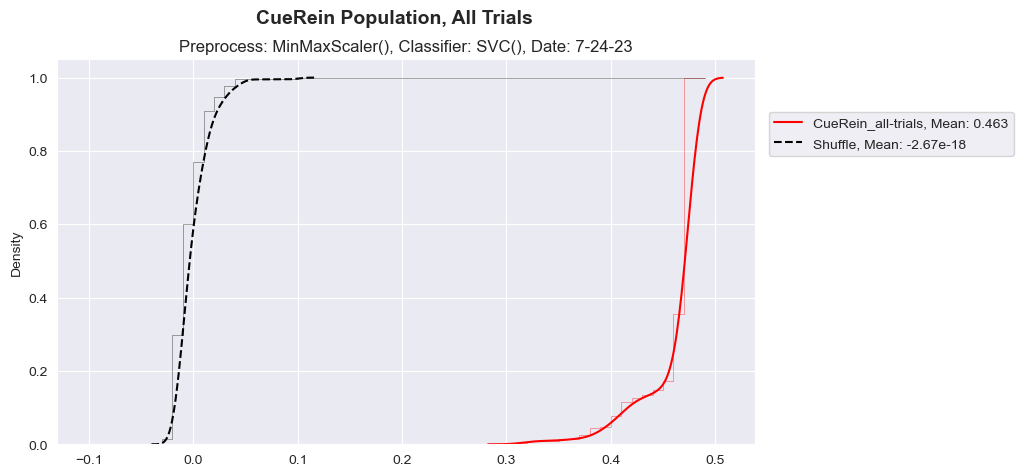

In [22]:
#plotting groups

groups = [
    'CueRein_all-trials', 
    ]

colors = ['red', 'green', 'blue']
bins = np.arange(-0.1,0.5,0.01)
sns.set_style('darkgrid')
plt.rcParams["figure.figsize"] = (9,5)
all_shuffled = []
for index in range(len(groups)):
    group = groups[index]
    c = colors[index]
    decode_values = np.load(os.path.join(iteration_dictionaries, '%s_%s_decoding-dict.npy'%(date, group)))
    unshuffle = decode_values[0]
    shuffle = decode_values[1]
    shuffle_mean = np.mean(shuffle)
    unshuffle = unshuffle - shuffle_mean #normalize by subtracting mean of shuffled data from unshuffled data
    shuffle = shuffle - shuffle_mean
    for neuron_accuracy in shuffle:
        all_shuffled.append(neuron_accuracy)
    sns.kdeplot(
        unshuffle, 
        label='%s, Mean: %s'%(group, '{0:.3g}'.format(np.mean(np.array(unshuffle)))), 
        cumulative=True, 
        color=c
        )
    sns.histplot(
        unshuffle,
        element='step',
        fill=False,
        cumulative=True,
        stat='density',
        bins=bins,
        color=c,
        alpha=.5,
        linewidth=.5
        )
sns.kdeplot(all_shuffled, label='Shuffle, Mean: %s'%('{0:.3g}'.format(np.mean(np.array(all_shuffled)))), cumulative=True, color='k', linestyle='--')
sns.histplot(
        all_shuffled,
        element='step',
        fill=False,
        cumulative=True,
        stat='density',
        bins=bins,
        color='k',
        alpha=.5,
        linewidth=.5
        )
plt.legend(loc=(1.02,.75), fontsize=10)
plt.suptitle('CueRein Population, All Trials', fontsize=14, fontweight='bold')
plt.title('Preprocess: %s, Classifier: %s, Date: %s'%(str(pipe['scaler']), str(pipe['classifier']), date))

plt.savefig(os.path.join(iteration_results, 'CueRein_Population_all-trials.PDF'), format='PDF', bbox_inches="tight")

plt.show()

CueRein_all-trials


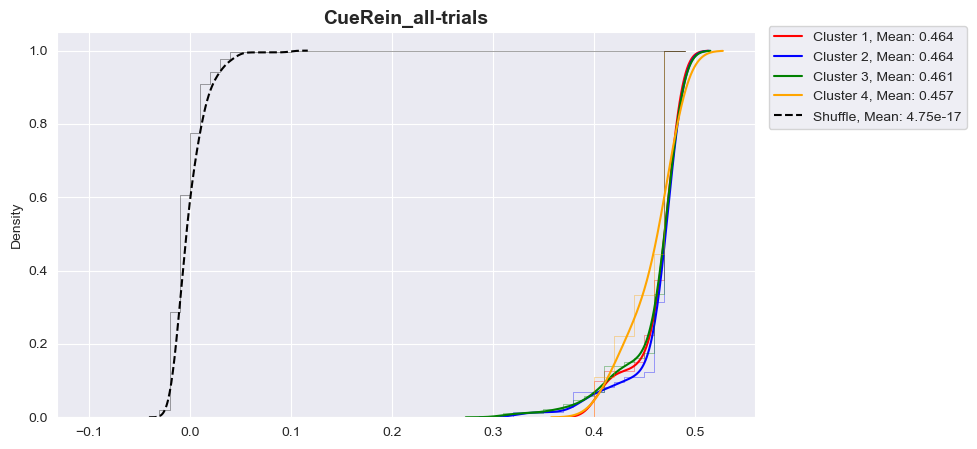

In [19]:
#plotting clusters per group

groups = [
    'CueRein_all-trials', 
    ]
labels_dir = [ALL_cueRein_labels]

colors=['red', 'blue', 'green', 'orange']
bins = np.arange(-.1,.5,0.01)
for index in range(len(groups)):
    print(groups[index])
    group = groups[index]
    cluster_labels = labels_dir[index]
    decode_values = np.load(os.path.join(iteration_dictionaries, '%s_%s_decoding-dict.npy'%(date, group)))
    unshuffle = decode_values[0]
    shuffle = decode_values[1]
    cluster_all_shuffle = []
    for c, cluster in enumerate(uniquelabels): 
        cluster_unshuffle_values = unshuffle[np.where(cluster_labels[:unshuffle.shape[0]]==c)]
        cluster_shuffle_values = shuffle[np.where(cluster_labels[:shuffle.shape[0]]==c)]
        cluster_shuffled_mean = np.mean(cluster_shuffle_values)
        cluster_unshuffle_values = cluster_unshuffle_values - cluster_shuffled_mean #normalize by subtracting mean shuffled values of cluster
        cluster_shuffle_values = cluster_shuffle_values -  cluster_shuffled_mean
        for neuron_accuracy in cluster_shuffle_values:
            cluster_all_shuffle.append(neuron_accuracy)
        sns.set_style('darkgrid')
        sns.kdeplot(
            cluster_unshuffle_values, 
            label='Cluster %s, Mean: %s'%(cluster+1, '{0:.3g}'.format(np.mean(cluster_unshuffle_values))), 
            cumulative=True, 
            color=colors[c])
        sns.histplot(
            cluster_unshuffle_values,
            element='step',
            fill=False,
            cumulative=True,
            stat='density',
            bins=bins,
            color=colors[c],
            alpha=.5,
            linewidth=.5
        )
    sns.kdeplot(
        cluster_all_shuffle, 
        label='Shuffle, Mean: %s'%('{0:.3g}'.format(np.mean(cluster_all_shuffle))), 
        cumulative=True, 
        color='k', 
        linestyle='--')
    sns.histplot(
            cluster_all_shuffle,
            element='step',
            fill=False,
            cumulative=True,
            stat='density',
            bins=bins,
            color='k',
            alpha=.5,
            linewidth=.5
        )
    plt.title(group, fontsize=14, fontweight='bold')
    plt.legend(loc=(1.02,.75), fontsize=10)

    plt.savefig(os.path.join(iteration_results, '%s_all-trials_Clusters.PDF'%(group)), format='PDF', bbox_inches="tight")
    
    plt.show()

#### Cluster Comparison

In [10]:
#making cohort dataframes for days and clusters

LCDD_shuffle = []
LCDD_unshuffle = []
groups = ['CueRein_averaged-trials']
labels_dir = [ALL_cueRein_labels]
for index in range(len(groups)):
    group = groups[index]
    newlabels = labels_dir[index]
    decode_values = np.load(os.path.join(iteration_dictionaries, '%s_%s_decoding-dict.npy'%(date, group)))
    unshuffle = decode_values[0]
    shuffle = decode_values[1]
    temp = []
    for c, cluster in enumerate(uniquelabels): 
        cluster_unshuffle_values = unshuffle[np.where(newlabels[:unshuffle.shape[0]]==c)]
        cluster_shuffle_values = shuffle[np.where(newlabels[:shuffle.shape[0]]==c)]
        LCDD_unshuffle.append({'Group': group, 'Cluster': c+1, 'Data': cluster_unshuffle_values})
        LCDD_shuffle.append({'Group': group, 'Cluster': c+1, 'Data': cluster_shuffle_values})
LCDD_unshuffle = pd.DataFrame(LCDD_unshuffle)
LCDD_shuffle = pd.DataFrame(LCDD_shuffle)

LCDD_day_cluster_means = []
LCDD_day_cluster_stats = []
for index in range(len(groups)):
    group = groups[index]
    newlabels = labels_dir[index]
    decode_values = np.load(os.path.join(iteration_dictionaries, '%s_%s_decoding-dict.npy'%(date, group)))
    unshuffle = decode_values[0]
    shuffle = decode_values[1]
    temp = []
    temp.append(group)
    for c, cluster in enumerate(uniquelabels): 
        if c==0:
            actual_c = 3
        elif c==1:
            actual_c = 0
        elif c==2:
            actual_c = 2
        elif c==3:
            actual_c = 1
        unshuffle_values = np.array(LCDD_unshuffle['Data'][LCDD_unshuffle['Group']==group][LCDD_unshuffle['Cluster']==actual_c+1])[0]
        shuffle_values = np.array(LCDD_shuffle['Data'][LCDD_shuffle['Group']==group][LCDD_shuffle['Cluster']==actual_c+1])[0]
        cluster_shuffle_mean = np.mean(shuffle_values)
        unshuffle_values = unshuffle_values - cluster_shuffle_mean #normalize cluster unshuffled data
        shuffle_values = shuffle_values - cluster_shuffle_mean
        median = np.median(unshuffle_values)
        """
        Median value had the best representative results of the data in comparison to mean and T-value, but can be changed
        to either by simply changing what is appended to 'temp' array.
        """
        temp.append(median)
        mean = np.nanmean(unshuffle_values)
        test = stats.ttest_ind(unshuffle_values, shuffle_values)
        if test[1] < .01: #comparing significance levels
            LCDD_day_cluster_stats.append({'Group': group, 
                                        'Cluster': actual_c+1,
                                        'T-val': '{0:.3g}'.format(test[0]), 
                                        'P-val': '{0:.3g}**'.format(test[1]), 
                                        'Mean': '{0:.3g}'.format(mean)})
        elif test[1] < .05:
            LCDD_day_cluster_stats.append({'Group': group, 
                                        'Cluster': actual_c+1,
                                        'T-val': '{0:.3g}'.format(test[0]), 
                                        'P-val': '{0:.3g}*'.format(test[1]), 
                                        'Mean': '{0:.3g}'.format(mean)})
        else:
            LCDD_day_cluster_stats.append({'Group': group, 
                                        'Cluster': actual_c+1,
                                        'T-val': '{0:.3g}'.format(test[0]), 
                                        'P-val': '{0:.3g}'.format(test[1]), 
                                        'Mean': '{0:.3g}'.format(mean)})
    LCDD_day_cluster_means.append(temp)
LCDD_stats_df = pd.DataFrame.from_dict(LCDD_day_cluster_stats).sort_values('Cluster')

Gi_shuffle = []
Gi_unshuffle = []
groups = [
    'CueRein_all-trials', 
    ]
labels_dir = [ALL_cueRein_labels]
for index in range(len(groups)):
    group = groups[index]
    decode_values = np.load(os.path.join(iteration_dictionaries, '%s_%s_decoding-dict.npy'%(date, group)))
    unshuffle = decode_values[0]
    shuffle = decode_values[1]
    newlabels = labels_dir[index]    
    temp = []
    for c, cluster in enumerate(uniquelabels): 
        cluster_unshuffle_values = unshuffle[np.where(newlabels[:unshuffle.shape[0]]==c)]
        cluster_shuffle_values = shuffle[np.where(newlabels[:shuffle.shape[0]]==c)]
        Gi_unshuffle.append({'Group': group, 'Cluster': c+1, 'Data': cluster_unshuffle_values})
        Gi_shuffle.append({'Group': group, 'Cluster': c+1, 'Data': cluster_shuffle_values})
Gi_unshuffle = pd.DataFrame(Gi_unshuffle)
Gi_shuffle = pd.DataFrame(Gi_shuffle)

Gi_day_cluster_means = []
Gi_day_cluster_stats = []
for index in range(len(groups)):
    group = groups[index]
    decode_values = np.load(os.path.join(iteration_dictionaries, '%s_%s_decoding-dict.npy'%(date, group)))
    unshuffle = decode_values[0]
    mean_shuffle = np.mean(decode_values[1])
    unshuffle = unshuffle - mean_shuffle   
    newlabels = labels_dir[index]    
    temp = []
    temp.append(group)
    for c, cluster in enumerate(uniquelabels): 
        if c==0:
            actual_c = 0
        elif c==1:
            actual_c = 2
        elif c==2:
            actual_c = 3
        elif c==3:
            actual_c = 1
        unshuffle_values = np.array(Gi_unshuffle['Data'][Gi_unshuffle['Group']==group][Gi_unshuffle['Cluster']==actual_c+1])[0]
        shuffle_values = np.array(Gi_shuffle['Data'][Gi_shuffle['Group']==group][Gi_shuffle['Cluster']==actual_c+1])[0]
        cluster_shuffle_mean = np.mean(shuffle_values)
        unshuffle_values = unshuffle_values - cluster_shuffle_mean #normalize cluster unshuffled data
        shuffle_values = shuffle_values - cluster_shuffle_mean
        median = np.median(unshuffle_values)
        temp.append(median)
        mean = np.nanmean(unshuffle_values)
        test = stats.ttest_ind(unshuffle_values, shuffle_values)
        if test[1] < .01:
            Gi_day_cluster_stats.append({'Group': group, 
                                        'Cluster': actual_c+1,
                                        'T-val': '{0:.3g}'.format(test[0]), 
                                        'P-val': '{0:.3g}**'.format(test[1]), 
                                        'Mean': '{0:.3g}'.format(mean)})
        elif test[1] < .05:
            Gi_day_cluster_stats.append({'Group': group, 
                                        'Cluster': actual_c+1,
                                        'T-val': '{0:.3g}'.format(test[0]), 
                                        'P-val': '{0:.3g}*'.format(test[1]), 
                                        'Mean': '{0:.3g}'.format(mean)})
        else:
            Gi_day_cluster_stats.append({'Group': group, 
                                        'Cluster': actual_c+1,
                                        'T-val': '{0:.3g}'.format(test[0]), 
                                        'P-val': '{0:.3g}'.format(test[1]), 
                                        'Mean': '{0:.3g}'.format(mean)})
    Gi_day_cluster_means.append(temp)
Gi_stats_df = pd.DataFrame.from_dict(Gi_day_cluster_stats).sort_values('Cluster')

df1 = pd.DataFrame(LCDD_day_cluster_means, 
                   columns=['Day', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
df2 = pd.DataFrame(Gi_day_cluster_means, 
                   columns=['Day', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])

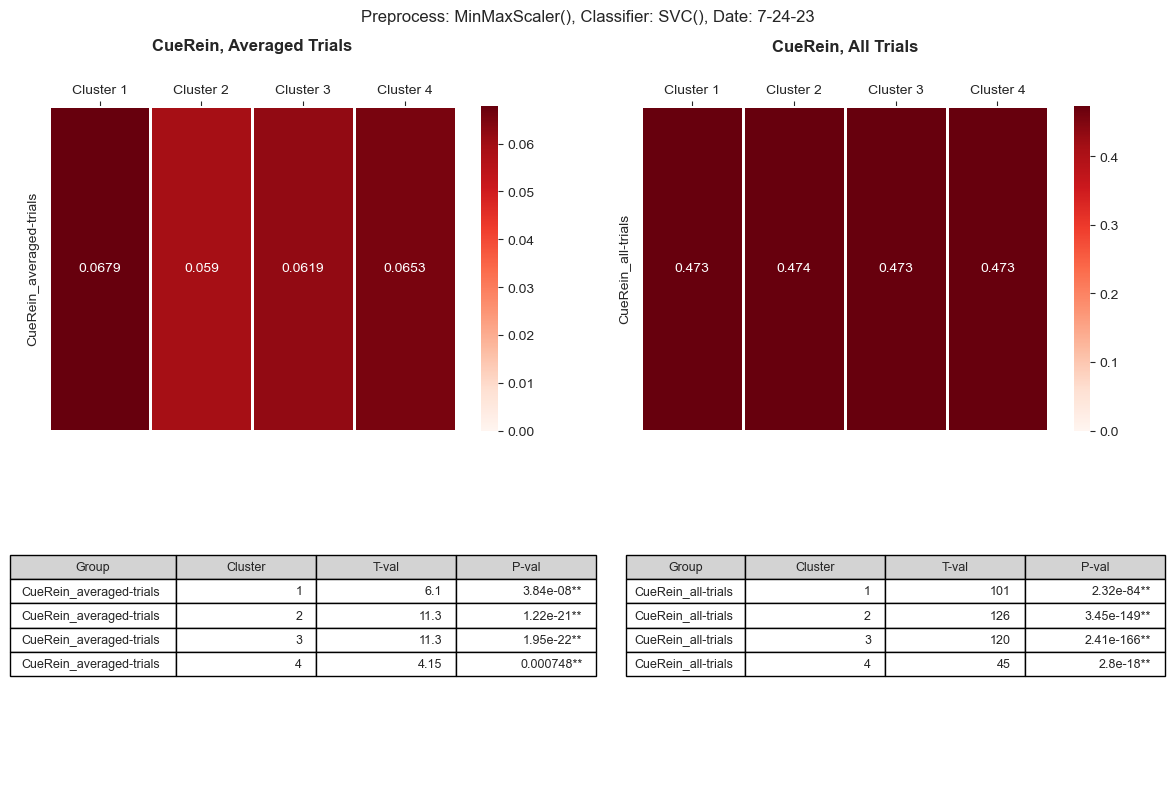

In [23]:
#plotting cohort day cluster heatmaps

fig, ax = plt.subplots(2,2, figsize=(12,8))
sns.heatmap(df1[['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']], 
            yticklabels=df1['Day'],
            cmap=plt.get_cmap('Reds'),
            vmin=0,
            annot=True,
            linewidths=1,
            fmt='.3',
            ax=ax[0,0])
ax[0,0].xaxis.tick_top()
ax[0,0].set_title('CueRein, Averaged Trials', fontweight='bold', pad=40)

ax[1,0].axis('off')
cell_text = []
for row in range(len(LCDD_stats_df)):
    cell_text.append(LCDD_stats_df[['Group', 'Cluster', 'T-val', 'P-val']].iloc[row])
table = ax[1,0].table(cellText=cell_text, colLabels=LCDD_stats_df.columns, colColours =["lightgrey"]*10, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.auto_set_column_width(False)
table.scale(1.1, 1.25)

sns.heatmap(df2[['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']], 
            yticklabels=df2['Day'],
            cmap=plt.get_cmap('Reds'),
            vmin=.0,
            annot=True,
            linewidths=1,
            fmt='.3',
            ax=ax[0,1])
ax[0,1].xaxis.tick_top()
ax[0,1].set_title('CueRein, All Trials', fontweight='bold', pad=40)

ax[1,1].axis('off')
cell_text = []
for row in range(len(Gi_stats_df)):
    cell_text.append(Gi_stats_df[['Group', 'Cluster', 'T-val', 'P-val']].iloc[row])
table = ax[1,1].table(cellText=cell_text, colLabels=Gi_stats_df.columns, colColours =["lightgrey"]*10, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.auto_set_column_width(False)
table.scale(1.1, 1.25)

fig.suptitle('Preprocess: %s, Classifier: %s, Date: %s'%(str(pipe['scaler']), str(pipe['classifier']), date))
fig.tight_layout()

plt.savefig(os.path.join(iteration_results, 'CueRein_Population_cluster-median-values_results.PDF'), format='PDF')

plt.show()